## Attribution Modelling and Budget Optimization

Marketa Analytics came across this blog and is intrigued on using the LTA and Logistic regression approach to determine the weights that can be attributed to campaigns. 

>In its most basic form, an attribution model is a rule, or set of rules, that determines how your analytics tool applies credit for clicks, form completions, and conversions.

**In fact, there’s no such thing as the “perfect attribution model”.**

https://blog.griddynamics.com/cross-channel-marketing-spend-optimization-deep-learning/

They intend to choose the best model amongst the 5 models based on ROI generated (See Budget optimization section in the article). They are asking your team to help implement this.

1. Start here: https://github.com/ikatsov/tensor- house/blob/master/promotions/channel-attribution-lstm.ipynb
2. Ignore the LSTM parts of the code and work on the LTA and Logistic regression algorithms.
3. Research on how to implement the four models in Python
4. Cite your sources and implement four functions to try out the four models.
5. Simulate ROI for each of the 4 models and show which model you would recommend.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import dask
import dask.dataframe as dd

from scipy.optimize import minimize
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
%pylab inline

plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x.astype(np.float))
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    #taking the campaign column values nad returning a dictionary with the campaign number and if the 
    #campaign shows first or not for that uid 
    #eg : for uid ='24607497' mapper will be = {'8847610': 0, '243786360': 1}
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        #creating a series of zeroes based on the length of mapper
        # for the above example and uid v= [0. 0.]
        v = np.zeros( len(mapper) )
       
        #assigning 1 & 0 for the campaigns for that uid
        # for eg: for uid ='24607497' 
        #       -> campaign = 884761  'campaigns' column will be [1,0] as its frist campaign for the uid
        #       -> campaign = 24378636 'campaigns' column will be [0,1] as its the second campaign for the uid
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 600

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

983094
[493391, 489703]


In [4]:
df6.shape

(983094, 27)

In [5]:
df6['day'] = np.floor(df6.timestamp / 86400.).astype(int)

In [6]:
df6.head(5)

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day
665452,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
888231,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,138937,1795451,29196072,15351056,28474333_-1,7.487274e-07,0.003426,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
547684,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
129131,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,26597096,4480345,29196072,29196072,25357769_-1,1.123091e-06,0.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
122009,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,1973606,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [12]:
# df6.to_csv('criteo_600.csv.gz',index=False, chunksize = 100000,compression='gzip')

# # df6.to_csv('criteo_600.csv.gz'
# #          , sep='|'
# #          , header=True
# #          , index=False
# #          , chunksize=100000
# #          , encoding='utf-8')

### How the one-hot encoding is done for the campaigns columns?

In [144]:
df8 = df6.loc[df6['uid'].isin([24607497,9999223])]
df8

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
513132,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,1.635258e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",884761
589344,227,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,8.498056e-05,1.636126e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",884761
435589,327380,24607497,24378636,0,-1,-1,0,0,-1,-1,...,11409686,1973606,28166623,5824233,29196072,24607497_-1,1.225592e-01,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",24378636
139571,387257,9999223,25391297,1,762827,11861724,0,1,12,14,...,32440044,1973606,26745255,5824233,8661623,9999223_11861724,1.449750e-01,2.365115e-01,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25391297
5141,422169,24607497,884761,0,-1,-1,0,1,-1,-1,...,11409686,1973606,27926977,26597096,8661620,24607497_-1,1.580448e-01,3.263988e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",884761
448409,560544,24607497,24378636,0,-1,-1,0,1,-1,-1,...,11409686,1973606,28166623,9312274,29196072,24607497_-1,2.098473e-01,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",24378636
238217,590673,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,27926977,9312274,21091108,24607497_-1,2.211265e-01,6.500962e-02,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",884761
566476,754786,9999223,25391297,1,762827,11861724,0,1,13,14,...,32440044,1973606,9290652,9068204,21091111,9999223_11861724,2.825645e-01,1.417939e-01,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25391297
130610,800617,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,27926977,9312274,21091111,24607497_-1,2.997220e-01,1.460065e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",884761
551965,944165,24607497,24378636,0,-1,-1,0,0,-1,-1,...,11409686,1973606,28166623,29196072,21091111,24607497_-1,3.534611e-01,1.480023e-01,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",24378636


In [130]:
values = '8847610'
column_names = ['campaign']
mapper= {}

for i, col_name in enumerate(column_names):
    for val in df8[col_name].unique():
        mapper[str(val) + str(i)] = len(mapper)
    print(mapper)    

{'8847610': 0, '243786360': 1}


In [131]:
v = np.zeros(len(mapper))
print(v)

[0. 0.]


In [134]:
for i, val in enumerate(values): 
    print('{},{}'.format(i,val))
    v[mapper[str(val) + str(i)]] = 1
print(mapper)
print(v)

0,8
1,8
2,4
3,7
4,6
5,1
6,0
{'8847610': 0, '243786360': 1, '80': 1, '81': 1, '42': 1, '73': 1, '64': 1, '15': 1, '06': 1}
[0. 1.]


In [145]:
map_one_hot(df8, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

{'8847610': 0, '243786360': 1, '253912970': 2}
[884761]
[884761]
[24378636]
[25391297]
[884761]
[24378636]
[884761]
[25391297]
[884761]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[884761]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[884761]
[884761]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[24378636]
[884761]
[884761]
[884761]
[24378636]
[884761]
[24378636]
[24378636]
[884761]
[24378636]


,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
513132,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,1.635258e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
589344,227,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,8.498056e-05,1.636126e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
435589,327380,24607497,24378636,0,-1,-1,0,0,-1,-1,...,11409686,1973606,28166623,5824233,29196072,24607497_-1,1.225592e-01,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 0.0]"
139571,387257,9999223,25391297,1,762827,11861724,0,1,12,14,...,32440044,1973606,26745255,5824233,8661623,9999223_11861724,1.449750e-01,2.365115e-01,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0]"
5141,422169,24607497,884761,0,-1,-1,0,1,-1,-1,...,11409686,1973606,27926977,26597096,8661620,24607497_-1,1.580448e-01,3.263988e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
448409,560544,24607497,24378636,0,-1,-1,0,1,-1,-1,...,11409686,1973606,28166623,9312274,29196072,24607497_-1,2.098473e-01,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]"
238217,590673,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,27926977,9312274,21091108,24607497_-1,2.211265e-01,6.500962e-02,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
566476,754786,9999223,25391297,1,762827,11861724,0,1,13,14,...,32440044,1973606,9290652,9068204,21091111,9999223_11861724,2.825645e-01,1.417939e-01,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0]"
130610,800617,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,27926977,9312274,21091111,24607497_-1,2.997220e-01,1.460065e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
551965,944165,24607497,24378636,0,-1,-1,0,0,-1,-1,...,11409686,1973606,28166623,29196072,21091111,24607497_-1,3.534611e-01,1.480023e-01,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]"


### Journey Length for the campaigns

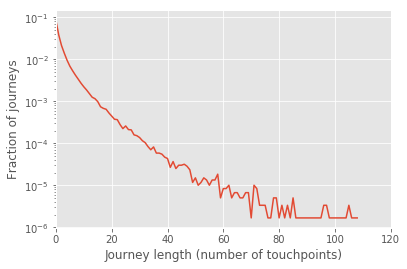

In [164]:
# Data exploration

def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df6)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## Last Touch Attribution

>In the last click attribution model, all of the revenue is attributed to the very last channel the customer interacted with before making the purchase.

**Last click attribution can show you what the final point is in your buying journey and what channels are most effective at turning anonymous visitors into leads**


In [4]:
def last_touch_attribution(df):
    
    # count the number of events for each campaign in df
    def count_by_campaign(df):
        #creating an array of zeroes for 600 campaigns
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            #print(campaign_one_hot)
            campaign_id = np.argmax(campaign_one_hot)
            #print(campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1
            #print(counters[campaign_id])
        return counters
    
    # count the number of impressions for each campaign   
    campaign_impressions = count_by_campaign(df)
    #print(campaign_impressions)
    
    # count the number of times the campaign is the last touch before the conversion
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    #print(idx)
    
    campaign_conversions = count_by_campaign(df_converted[idx])
    #print(campaign_conversions)
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

### Validating the LTA code with a specific UID

In [165]:
df6[df6['uid']==7306395]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day
190590,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,7306395_3063962,0.000001,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
34219,391213,7306395,29427842,1,1449193,3063962,0,1,1,7,...,1973606,9180723,29841067,21091111,7306395_3063962,0.146456,0.150930,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
170581,421106,7306395,29427842,1,1449193,3063962,0,1,2,7,...,1973606,9180723,23998111,9491351,7306395_3063962,0.157647,0.011533,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
157009,505427,7306395,29427842,1,1449193,3063962,0,1,3,7,...,1973606,16561097,3225256,29520629,7306395_3063962,0.189214,0.032532,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
128353,858727,7306395,29427842,1,1449193,3063962,0,1,4,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.321476,0.136304,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
307436,1160081,7306395,29427842,1,1449193,3063962,0,1,5,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.434292,0.116263,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
155312,1380702,7306395,29427842,1,1449193,3063962,0,1,6,7,...,1973606,18079314,29841067,21091108,7306395_3063962,0.516885,0.085116,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
530307,1458216,7306395,29427842,1,3673484,22468128,0,1,0,14,...,1973606,9180723,23998111,29520629,7306395_22468128,0.545903,0.029905,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16
456496,1507601,7306395,29427842,1,3673484,22468128,0,1,1,14,...,1973606,8896233,23998111,9491354,7306395_22468128,0.564391,0.019053,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17
257073,2668515,7306395,29427842,1,3673484,22468128,0,1,2,14,...,1973606,9180723,29841067,8661620,7306395_22468128,0.998995,0.447884,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30


In [167]:
df_converted_1 = df6[df6['conversion'] == 1]
df_converted_1=df_converted_1[df_converted_1['jid']=='7306395_3063962']
df_converted_1

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day
190590,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,7306395_3063962,0.000001,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
34219,391213,7306395,29427842,1,1449193,3063962,0,1,1,7,...,1973606,9180723,29841067,21091111,7306395_3063962,0.146456,0.150930,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
170581,421106,7306395,29427842,1,1449193,3063962,0,1,2,7,...,1973606,9180723,23998111,9491351,7306395_3063962,0.157647,0.011533,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
157009,505427,7306395,29427842,1,1449193,3063962,0,1,3,7,...,1973606,16561097,3225256,29520629,7306395_3063962,0.189214,0.032532,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
128353,858727,7306395,29427842,1,1449193,3063962,0,1,4,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.321476,0.136304,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
307436,1160081,7306395,29427842,1,1449193,3063962,0,1,5,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.434292,0.116263,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
155312,1380702,7306395,29427842,1,1449193,3063962,0,1,6,7,...,1973606,18079314,29841067,21091108,7306395_3063962,0.516885,0.085116,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15


In [168]:
jid = '7306395_3063962'
idx = df_converted_1.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted_1['timestamp_norm']
idx

190590    False
34219     False
170581    False
157009    False
128353    False
307436    False
155312     True
Name: timestamp_norm, dtype: bool

In [169]:
    # count the number of events for each campaign in df
    def count_by_campaign(df):
        #creating an array of zeroes for 400 campaigns
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            print(campaign_one_hot)
            campaign_id = np.argmax(campaign_one_hot)
            print(campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1
            print(counters[campaign_id])
        return counters

In [170]:
campaign_conversions = count_by_campaign(df_converted_1[idx])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [48]:
df_converted[['jid', 'timestamp_norm']]

,jid,timestamp_norm
22490,7306395_3063962,0.000001
542344,6013772_15587012,0.000009
605763,9451380_4136014,0.000011
362847,2380977_28647208,0.000035
171722,3208958_20579181,0.000038
...,...,...
181488,32118557_8167674,0.999990
404680,4642451_26124643,0.999991
721244,19065515_24966585,0.999991
463140,14549073_24487325,0.999992


In [65]:
g = pd.DataFrame(df6.groupby(['uid','campaign'])['campaign'].count())
g.head(100)

,,campaign
uid,campaign,
601,5061834,3
656,27777499,3
889,9100693,9
999,5061834,3
1694,8710016,2
...,...,...
16313,15398570,7
16399,15422821,3
16690,9100693,2


### Visualization of the attribution scores for 50 campaigns

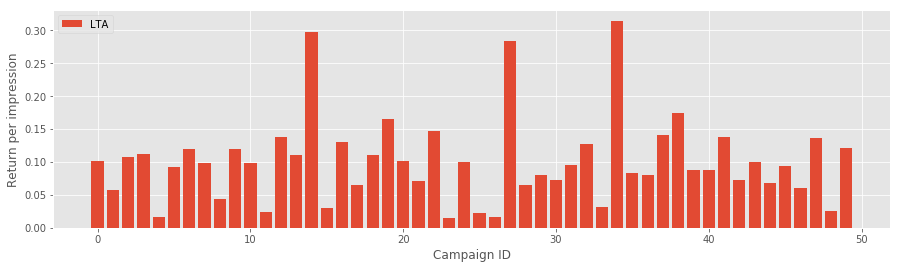

In [173]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## First Touch Attribution

>In the first click attribution model, all of the revenue generated from the sale is attributed to the very first campaign the customer interacted with

**First click attribution is good at showing you which of your campaigns is best at generating awareness and traffic**

In [5]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    #print(idx)
    campaign_conversions = count_by_campaign(df_converted[idx])
    #print(campaign_conversions)
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

### Validating the LTA code with a specific UID

In [175]:
df_converted_2 = df6[df6['conversion'] == 1]
df_converted_2=df_converted_2[df_converted_2['jid']=='7306395_3063962']
df_converted_2

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day
190590,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,7306395_3063962,0.000001,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
34219,391213,7306395,29427842,1,1449193,3063962,0,1,1,7,...,1973606,9180723,29841067,21091111,7306395_3063962,0.146456,0.150930,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
170581,421106,7306395,29427842,1,1449193,3063962,0,1,2,7,...,1973606,9180723,23998111,9491351,7306395_3063962,0.157647,0.011533,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
157009,505427,7306395,29427842,1,1449193,3063962,0,1,3,7,...,1973606,16561097,3225256,29520629,7306395_3063962,0.189214,0.032532,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
128353,858727,7306395,29427842,1,1449193,3063962,0,1,4,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.321476,0.136304,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
307436,1160081,7306395,29427842,1,1449193,3063962,0,1,5,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.434292,0.116263,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
155312,1380702,7306395,29427842,1,1449193,3063962,0,1,6,7,...,1973606,18079314,29841067,21091108,7306395_3063962,0.516885,0.085116,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15


In [177]:
jid = '7306395_3063962'
idx = df_converted_2.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted_2['timestamp_norm']
idx

190590     True
34219     False
170581    False
157009    False
128353    False
307436    False
155312    False
Name: timestamp_norm, dtype: bool

In [178]:
campaign_conversions = count_by_campaign(df_converted_2[idx])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [18]:
df_converted.groupby(['jid'])['timestamp_norm'].min()

jid
1000023_5282678      0.500511
10000403_29178244    0.398285
10000523_19113736    0.121671
10000523_2559380     0.183451
10000953_28271511    0.635540
                       ...   
9999223_11861724     0.144975
9999669_4594367      0.284789
9999681_20315908     0.120151
9999748_25873601     0.156294
999_14996161         0.605421
Name: timestamp_norm, Length: 120006, dtype: float64

### Visualization of the attribution scores for 50 campaigns

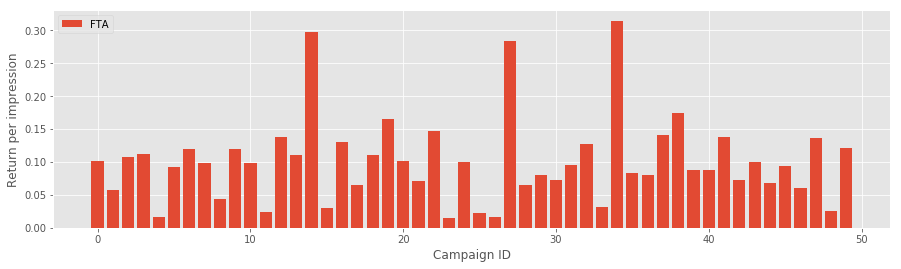

In [179]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## U-shaped Model

>U-shaped attribution is a multi-touch option that will prioritise the first anonymous touchpoint that initiated the visitor and the lead conversion touch-point.
The U-Shaped attribution model tracks every single touchpoint but will assign 40% to first and last-click.The remaining 20% is then split evenly among the other touchpoints.

The U-Shaped attribution model is great for telling you two things:

1. What channel is best for acquiring the most relevant audience.
2. What channel is most suitable for converting new sales.

It also assigns a portion of the credit to each touchpoint in the journey, whilst allowing you to optimise for the first and last-click attribution.

In [6]:
def u_shaped_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def count_by_ushape(df, idx_fta, idx_lta):
        #creating an array of zeroes for 600 campaigns
        counters = np.zeros(n_campaigns)
        for campaign_one_hot, fta_item, lta_item in zip(df['campaigns'].values, idx_fta, idx_lta):
            
            if(fta_item=='True'):
                campaign_id = np.argmax(campaign_one_hot)
                counters[campaign_id] = counters[campaign_id] + 1
            elif(lta_item=='True'):
                campaign_id = np.argmax(campaign_one_hot)
                counters[campaign_id] = counters[campaign_id] + 1 
            else:
                campaign_id = np.argmax(campaign_one_hot)
                counters[campaign_id] = counters[campaign_id] + 0.5
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx_fta = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    idx_lta = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_ushape(df_converted, idx_fta, idx_lta)

        
    return campaign_conversions / campaign_impressions
    
usa = u_shaped_attribution(df6)

### Visualization of the attribution scores for 50 campaigns

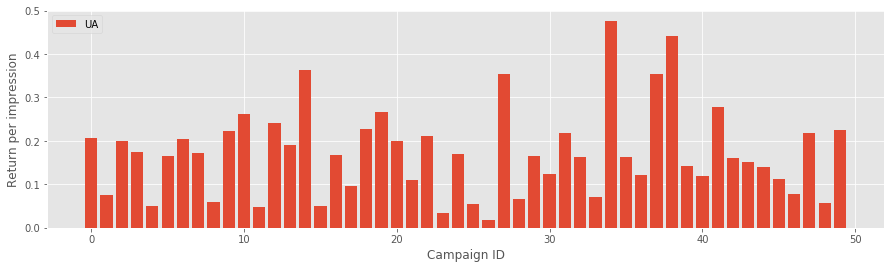

In [188]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(usa[campaign_idx])), usa[campaign_idx], label='UA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Linear Attribution Model

>In the linear attribution model, revenue from the sale is distributed evenly across all of the touchpoints in the buyer’s journey

**The linear attribution model would divide the revenue generated by four, attributing 25% of the sale to each of those campaigns**

Unlike first click and last click, linear attribution makes sure every campaign and channel that played a part in the journey gets equal credit for the conversion.

In [7]:
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted['timestamp_norm'] == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    #print(campaign_conversions)
        
    return campaign_conversions / campaign_impressions
    
la = linear_attribution(df6)

### Visualization of the attribution scores for 50 campaigns

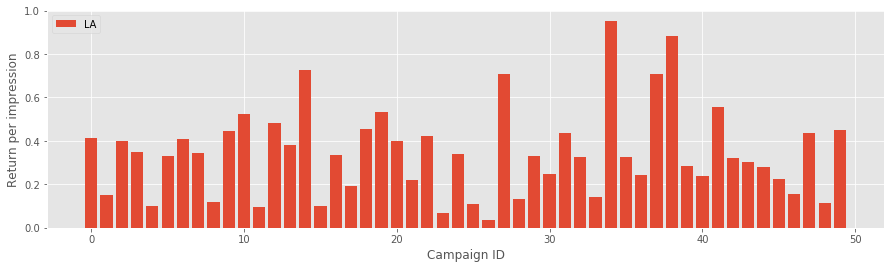

In [190]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(la[campaign_idx])), la[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Time-Decay Attribution Model

>In the time decay attribution model, revenue from the sale is distributed to all marketing touchpoints, but the most recent touchpoints receive a higher percentage of credit than the earlier ones

Time decay is good for showing you two things.

Like Linear Attribution, it shows you all of the campaigns and channels that played a part in generating the conversion.
It also shows you which of your campaigns/channels do the best job of getting leads to convert into a sale.

In [8]:
def time_decay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def count_by_tda(df,idx_lta,steps_df):
        #creating an array of zeroes for 600 campaigns
        counters = np.zeros(n_campaigns)
        for campaign_one_hot, lta_item, jid_item in zip(df['campaigns'].values, idx_lta, df['jid']):
            jid_item = str(jid_item)
            
            if(lta_item==True):
                campaign_id = np.argmax(campaign_one_hot)
                counters[campaign_id] = counters[campaign_id] + 1

            else:
                if(steps_df.loc[jid_item, 'steps']!=0):
                    if(steps_df.loc[jid_item, 'weight']!=0):
                        campaign_id = np.argmax(campaign_one_hot)
                        counters[campaign_id] = counters[campaign_id] + (steps_df.loc[jid_item, 'weight'] - 0.1)
                        steps_df.loc[jid_item, 'weight'] = round((steps_df.loc[jid_item, 'weight'] - 0.1),1)
                        steps_df.loc[jid_item, 'steps'] = steps_df.loc[jid_item, 'steps'] - 1
                    else:
                        steps_df.loc[jid_item, 'steps'] -= 1
                
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    steps_df = pd.DataFrame(df_converted.groupby(['jid'])['jid'].count()-1)
    steps_df.columns = ['steps']
    steps_df['weight'] = 1
    
    idx_lta = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_tda(df_converted, idx_lta, steps_df)
   
        
    return campaign_conversions / campaign_impressions
    
tda = time_decay_attribution(df6)

### Validating the model for a specific UID

In [257]:
df_converted = df6[df6['conversion'] == 1]
df_converted=df_converted[df_converted['jid']=='7306395_3063962']
df_converted

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day
22490,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,7306395_3063962,0.000001,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
16103,391213,7306395,29427842,1,1449193,3063962,0,1,1,7,...,1973606,9180723,29841067,21091111,7306395_3063962,0.146456,0.150930,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
275152,421106,7306395,29427842,1,1449193,3063962,0,1,2,7,...,1973606,9180723,23998111,9491351,7306395_3063962,0.157647,0.011533,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
206075,505427,7306395,29427842,1,1449193,3063962,0,1,3,7,...,1973606,16561097,3225256,29520629,7306395_3063962,0.189214,0.032532,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
190981,858727,7306395,29427842,1,1449193,3063962,0,1,4,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.321476,0.136304,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
348931,1160081,7306395,29427842,1,1449193,3063962,0,1,5,7,...,1973606,16561097,29841067,21091111,7306395_3063962,0.434292,0.116263,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
777770,1380702,7306395,29427842,1,1449193,3063962,0,1,6,7,...,1973606,18079314,29841067,21091108,7306395_3063962,0.516885,0.085116,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15


In [280]:
jid = '7306395_3063962'
steps_df.loc[jid,'weight'] - 0.1

0.9

In [233]:
x.loc[df6['jid']]['steps']!=0

jid
24607497_-1          True
25357769_-1          True
7306395_3063962      True
93907_-1             True
19923387_-1          True
                     ... 
32118557_8167674     True
4642451_26124643     True
19065515_24966585    True
14549073_24487325    True
11373089_18502870    True
Name: steps, Length: 863835, dtype: bool

### Visualization of the attribution scores for 50 campaigns

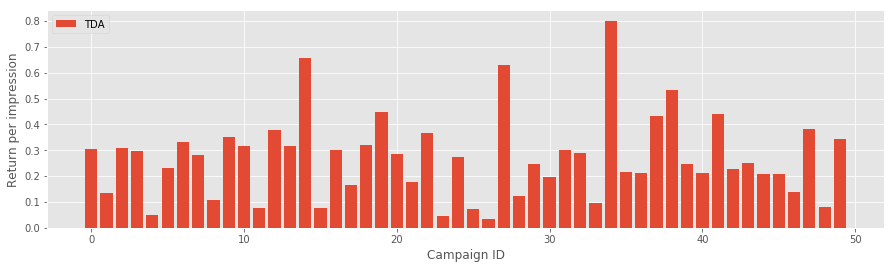

In [192]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(tda[campaign_idx])), tda[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [ ]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [ ]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [ ]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

In [ ]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

## Budget Optimization

In [110]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [113]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [116]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0]
attributions = [lta,fta,usa,tda,la]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(pitch, j, reward))

0.1 0 : 1672
0.25 0 : 1540
0.5 0 : 1272
1.0 0 : 192
1.5 0 : 262
2.0 0 : 335
2.5 0 : 372
3.0 0 : 407


## Bokeh Visualizations

### All 5 attribution model visualization

In [72]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output
from collections import defaultdict

from bokeh.layouts import gridplot, column,layout, row
from bokeh.io import output_notebook
from bokeh.models import CustomJS, Slider, ColumnDataSource, FactorRange, HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.models.widgets import Dropdown, CheckboxGroup
from bokeh.transform import dodge, jitter

output_notebook()

Loading BokehJS ...

In [212]:
CampaignID = np.array([str(i) for i in range(0, 400)])
class_list = ['FTA', 'LTA', 'LA', 'TDA', 'USA']
data = {
    'CampaignID' : CampaignID,
    'FTA' : fta[0:400],
    'LTA' : lta[0:400],
    'LA' : la[0:400],
    'TDA' : tda[0:400],
    'USA' : usa[0:400]
}
source = ColumnDataSource(data=data)

In [245]:
lb = widgets.BoundedIntText(
    value=100,
    min=0,
    max=399,
    step=1,
    description='Lower Bound:'
)

ub = widgets.BoundedIntText(
    value=120,
    min=0,
    max=399,
    step=1,
    description='Upper Bound:'
)

box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='center', width='100%')
hbox1 = widgets.HBox([lb, ub])
vbox1 = widgets.VBox([hbox1], layout=box_layout)

def show_graph(lb, ub):
    
    CampaignID = np.array([str(i) for i in range(lb, ub)])
    data = {
        'CampaignID' : CampaignID,
        'FTA' : fta[lb:ub],
        'LTA' : lta[lb:ub],
        'LA' : la[lb:ub],
        'TDA' : tda[lb:ub],
        'USA' : usa[lb:ub]
    }
    
    source = ColumnDataSource(data=data)
    
    p = figure(x_range=FactorRange(*CampaignID), plot_width=900, plot_height=600, title="Model Comparisons")
    p.xaxis.axis_label = "Campaign IDs"
    p.yaxis.axis_label = "Weights"
    p.background_fill_color = '#404040'
    
    p.vbar(x=dodge('CampaignID', -0.40, range=p.x_range), top='FTA', width=0.1, color='#d7191c', source=source, legend="First Touch")
    p.vbar(x=dodge('CampaignID', -0.20, range=p.x_range), top='LTA', width=0.1, color='#fdae61', source=source, legend="Last Touch")
    p.vbar(x=dodge('CampaignID', 0.0, range=p.x_range), top='LA', width=0.1, color='#ffffff', source=source, legend="Linear")
    p.vbar(x=dodge('CampaignID', 0.20, range=p.x_range), top='TDA', width=0.1, color='#abd9e9', source=source, legend="Time Decay")
    p.vbar(x=dodge('CampaignID', 0.40, range=p.x_range), top='USA', width=0.1, color='#2c7bb6', source=source, legend="U-Shape")
    
    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    p.legend.label_text_font = '#ffffff'
    p.legend.background_fill_color = '#bdbdbd'
    
    p.x_range.range_padding = 0.2
    p.xgrid.grid_line_color = None
    show(p)
        
box1 = interactive_output(show_graph, {'lb':lb, 'ub':ub})

In [246]:
model_A = widgets.Dropdown(
    options=class_list,
    value='FTA',
    description='Model A:')

model_B = widgets.Dropdown(
    options=class_list,
    value='LTA',
    description='Model B:')

box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='center', width='100%')
hbox = widgets.HBox([model_A, model_B])
vbox = widgets.VBox([hbox], layout=box_layout)

In [247]:
def show_compare(model_A, model_B, lb, ub):
    
    CampaignID = np.array([str(i) for i in range(lb, ub)])
    data = {
        'CampaignID' : CampaignID,
        'FTA' : fta[lb:ub],
        'LTA' : lta[lb:ub],
        'LA' : la[lb:ub],
        'TDA' : tda[lb:ub],
        'USA' : usa[lb:ub]
    }
    
    source = ColumnDataSource(data=data)
    
    p1 = figure(x_range=FactorRange(*CampaignID), plot_width=450, plot_height=450, title="Model "+model_A, toolbar_location=None)
    p1.xaxis.axis_label = "Campaign IDs"
    p1.yaxis.axis_label = "Weights"
    p1.background_fill_color = '#404040'
    p1.xgrid.grid_line_color = None
    p1.ygrid.grid_line_color = None
    
    p1.vbar(x=dodge('CampaignID', 0.0, range=p1.x_range), top=model_A, width=0.1, color='#d7191c', source=source)
    
    p2 = figure(x_range=FactorRange(*CampaignID), plot_width=450, plot_height=450, title="Model "+model_B, toolbar_location=None)
    p2.xaxis.axis_label = "Campaign IDs"
    p2.yaxis.axis_label = "Weights"
    p2.background_fill_color = '#404040'
    p2.xgrid.grid_line_color = None
    p2.ygrid.grid_line_color = None
    
    p2.vbar(x=dodge('CampaignID', 0.0, range=p2.x_range), top=model_B, width=0.1, color='#2c7bb6', source=source)
        
    show(row(p1,p2))
        
box = interactive_output(show_compare, {'model_A':model_A, 'model_B':model_B, 'lb':lb, 'ub':ub})

In [248]:
display(box, vbox, box1, vbox1)

Output()

Output(outputs=({'output_type': 'display_data', 'data': {'text/html': '\n\n\n\n\n\n  <div class="bk-root" id="…

### Budget Optimization Visualization

In [127]:
df_reward = pd.read_csv("rewards.csv")
df_reward['Pitch'] = df_reward['Pitch'].astype(str)
df_reward['Model'] = df_reward['Model'].astype(str)

df_reward.loc[df_reward['Model']=='0', 'Rewards'] = df_reward[df_reward['Model']=='0']['Rewards']+10
df_reward.loc[df_reward['Model']=='2', 'Rewards'] = df_reward[df_reward['Model']=='2']['Rewards']-10

In [128]:
source = ColumnDataSource(data={
    'pitch': df_reward['Pitch'].unique(),
    'LTA': df_reward[df_reward['Model']=='0']['Rewards'],
    'FTA': df_reward[df_reward['Model']=='1']['Rewards'],
    'USA': df_reward[df_reward['Model']=='2']['Rewards'],
    'TDA': df_reward[df_reward['Model']=='3']['Rewards'],
    'LA': df_reward[df_reward['Model']=='4']['Rewards']
})

In [129]:
p = figure(x_range=FactorRange(*df_reward['Pitch'].unique()), plot_width=900, plot_height=600, title="Reward Comparisons")
p.xaxis.axis_label = "Pitch"
p.yaxis.axis_label = "Reward"
p.background_fill_color = '#404040'

p.line(x='pitch', y='LTA', line_width=2, color='#d7191c', source=source, legend="Last Touch")
p.circle(x='pitch', y='LTA', color='#d7191c', source=source)
p.line(x='pitch', y='FTA', line_width=2, color='#fdae61', source=source, legend="First Touch")
p.circle(x='pitch', y='FTA', color='#fdae61', source=source)
p.line(x='pitch', y='USA', line_width=2, color='#ffffff', source=source, legend="U-Shape")
p.circle(x='pitch', y='USA', color='#ffffff', source=source)
p.line(x='pitch', y='TDA', line_width=2, color='#abd9e9', source=source, legend="Time Decay")
p.circle(x='pitch', y='TDA', color='#abd9e9', source=source)
p.line(x='pitch', y='LA', line_width=2, color='#2c7bb6', source=source, legend="Linear")
p.circle(x='pitch', y='LA', color='#2c7bb6', source=source)

p.add_tools(HoverTool(tooltips=[('LTA', '@LTA'),
                               ('FTA', '@FTA'),
                               ('USA', '@USA'),
                               ('TDA', '@TDA'),
                               ('LA', '@LA')]))

p.legend.location = "top_right"
p.legend.orientation = "horizontal"
p.legend.label_text_font = '#ffffff'
p.legend.background_fill_color = '#bdbdbd'

p.x_range.range_padding = 0.2
p.xgrid.grid_line_color = None
show(p)